# Clustering

This example makes generous use of this [notebook](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html), especially for plotting.

References:
    1. A tutorial on Spectral Clustering - Ulrike von Luxburg [arXiv](https://arxiv.org/abs/0711.0189) 
    2. Robust and multiway spectral clustering - Anil Damle, Victor Minden, Lexing Ying [arXiv](https://arxiv.org/abs/1609.08251)
    3. Python Data Science Handbook: [Chapter 5](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
    4. Scikit learn [website](http://scikit-learn.org/stable/index.html)
    

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# 1. K-means clustering

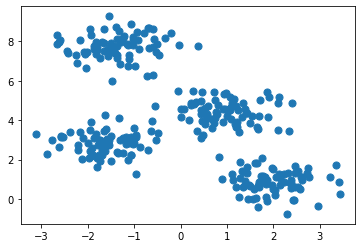

In [9]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s = 50);

In [10]:
# Basic implementation of kmeans clustering

from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    centerslst = list()
    labelslst = list()
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        centerslst.append(new_centers)
        labelslst.append(labels)
        
        # 2c. Check for convergence : norm is less than a factor of machine epsilon
        if np.linalg.norm(centers - new_centers) < 10.*np.finfo(float).eps:
            break    
            
        centers = new_centers
        
        
    return centerslst, labelslst



### Run kmeans and plot the centers along with the labels.

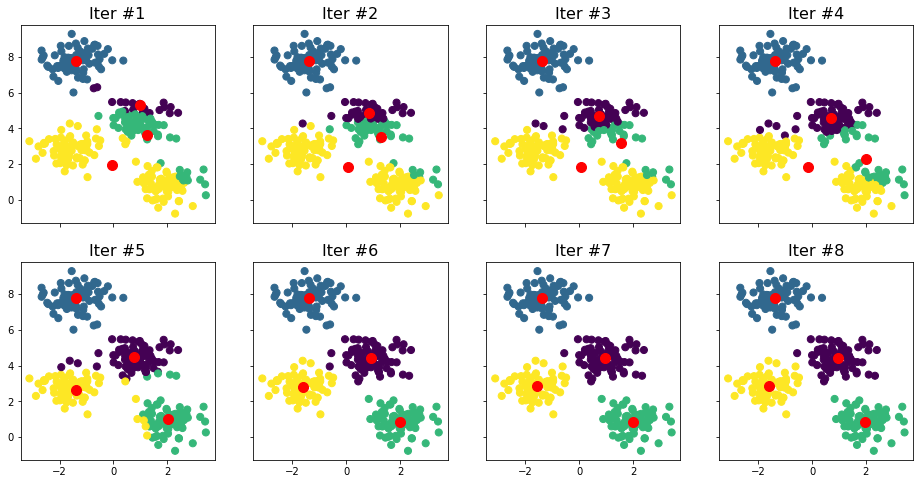

In [11]:
centerslst, labelslst = find_clusters(X, 4)

f, axarray = plt.subplots(2,4, sharex = True, sharey = True, figsize=(16,8))
for i, centers, label, ax in zip(range(len(centerslst)), centerslst, 
                                         labelslst, axarray.flatten()): 
    ax.scatter(X[:, 0], X[:, 1], c = label, s=50, cmap='viridis');
    ax.plot(centers[:,0],centers[:,1], 'ro', markersize = 10)
    ax.set_title('Iter #' + str(i+1), fontsize = 16)
    

###  An example in which k-means does poorly 

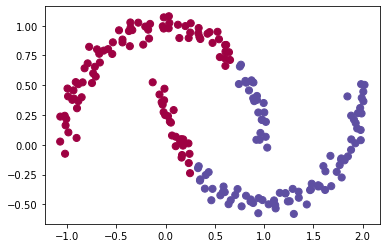

In [12]:
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='Spectral');

### A real dataset - Iris clustering

Text(0.5, 1.0, 'PCA + K-means')

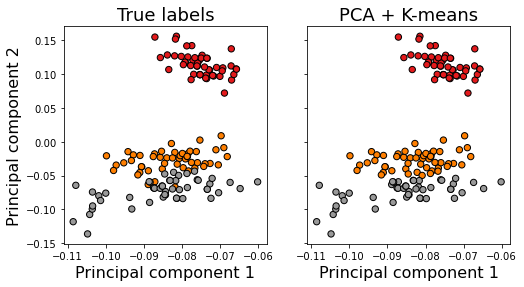

In [13]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris.data
y = iris.target

def mypca(S,nc):
    mu = np.mean(S,1)
    #Remove mean from the samples
    Ss = S - np.tile(mu[:,np.newaxis],(1,S.shape[1]))
    
    #Compute the SVD of the shifted matrix
    u,s,vh = np.linalg.svd(Ss, full_matrices = False)
    
    u = u[:,:nc]   #Principal directions
    s = s[:nc]     #Singular values that can be used to explain variance 
    
    return u, s

u,s = mypca(X,2)
clusters = KMeans(3, random_state=0).fit_predict(u)

# Reshuffle the labels
from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(y[mask])[0]

f, (ax1,ax2) = plt.subplots(1, 2, sharey = True, figsize=(8,4))
ax1.scatter(u[:,0],u[:,1], c = y, cmap=plt.cm.Set1, edgecolor='k', s=40)
ax1.set_xlabel('Principal component 1', fontsize = 16)
ax1.set_ylabel('Principal component 2', fontsize = 16)
ax1.set_title('True labels', fontsize  = 18)

ax2.scatter(u[:,0],u[:,1], c = labels, cmap=plt.cm.Set1, edgecolor='k', s=40)
ax2.set_xlabel('Principal component 1', fontsize = 16)
ax2.set_title('PCA + K-means', fontsize = 18)


# 2. Spectral Clustering

In [14]:
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import eigsh, aslinearoperator
from scipy.sparse import spdiags, identity
def spectralclustering(pts, kernel, n_neighbors = 2, method = 'normalized', n_clusters = None):
    
    # 1. Construct the similarity matrix
    R  = pairwise_distances(pts)
    W = kernel(R)
    np.fill_diagonal(W,0)     
    
    #Compute degree of the matrix
    d = W.sum(axis = 1).flatten()
    D = np.diag(d,0)
    
    
    # 2. Construct the appropriate laplacian and the eigenvectors
    if method == 'unnormalized':
        L = D - W
        
        l, v = eigsh(aslinearoperator(L), k = n_clusters, which = 'SM')
        X = v
        
    elif method == 'normalized': 
        # Computing the largest eigenvalues of D^{-1/2}WD^{-1/2}
        # equivalent to computing the smallest eigenvalues of L_sym = I - D^{-1/2}WD^{-1/2}
        
        Dinv12 = np.diag(1./np.sqrt(d),0)
        A = np.dot(Dinv12,np.dot(W,Dinv12))
        
        #This step can be replaced by a randomized subspace iteration
        l, v = eigsh(aslinearoperator(A), k = n_clusters)
        
        #Scale the rows by the row norms to normalized the vectors
        X = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, v.T)
        X = X.T
    else:
        raise NotImplementedError
    
    #Kmeans clustering
    kmeans = KMeans(n_clusters, random_state=0)
    labels = kmeans.fit_predict(X)
    centers = centers = kmeans.cluster_centers_
    
    return labels



### Example 1: Moons dataset

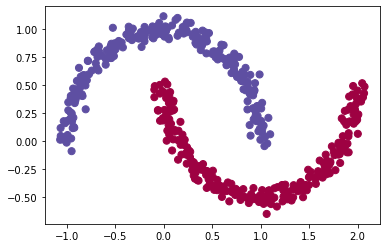

In [15]:
# Define the kernel
kernel = lambda x: np.exp(-(x/0.1)**2.)

# Construct moons
X, y = make_moons(500, noise=.05, random_state=0)
# Run spectral clustering
labels = spectralclustering(X, kernel, n_neighbors = 50, n_clusters = 2)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = labels, s=50, cmap='Spectral');


### Example 2: Circles Dataset

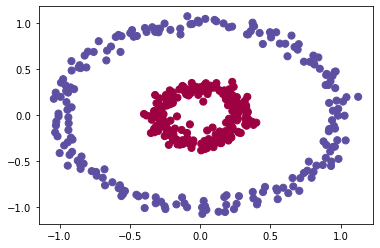

In [16]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

labels = spectralclustering(X, kernel, n_neighbors = 50, n_clusters = 2)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = labels, s=50, cmap='Spectral');

### Example 3: Handwriting digits 

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()

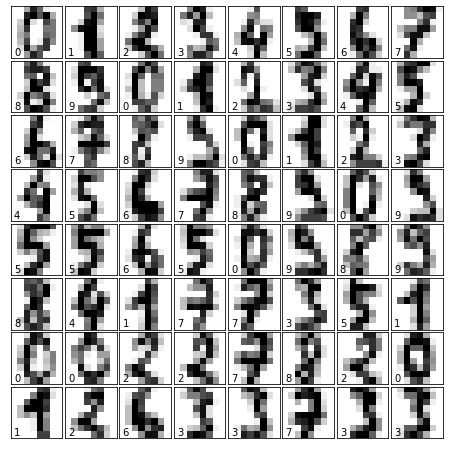

In [18]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [19]:
kernel = lambda x: np.exp(-(x/40.)**2.)
clusters = spectralclustering(digits.data, kernel, \
                                method = 'normalized', n_neighbors = 30, n_clusters = 10)
from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [21]:
from sklearn.metrics import accuracy_score
score = accuracy_score(digits.target, labels)

print("The fraction of correctly assigned labels is ", score)

The fraction of correctly assigned labels is  0.800222593210907


### Plot the confusion matrix. This is a method to study the accuracy of the classification.

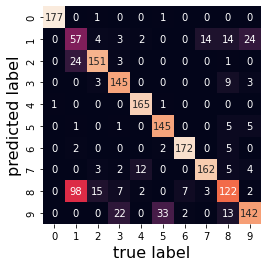

In [22]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label', fontsize = 16)
plt.ylabel('predicted label', fontsize = 16);

### Example 4. Image Segmentation

Text(0.5, 1.0, 'Noisy image')

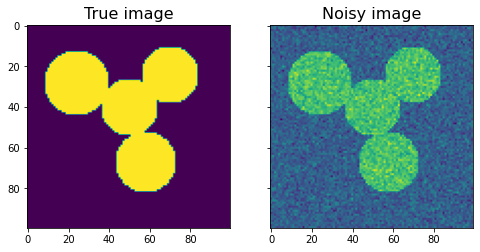

In [23]:
### Create the example image
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

mask = img.astype(bool)
img = img.astype(float)
imgn =  img + 1 + 0.2 * np.random.randn(*img.shape)

f, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,4))
ax1.imshow(img)
ax1.set_title('True image', fontsize = 16)
ax2.imshow(imgn)
ax2.set_title('Noisy image', fontsize = 16)

In [24]:
def spectralsegmentation(W, method = 'normalized', n_clusters = None):
 
    
    #Compute degree of the matrix
    d = W.sum(axis = 1).flatten()
    D = spdiags(d,0,W.shape[0],W.shape[1])
    
    # 2. Construct the appropriate laplacian and the eigenvectors
    if method == 'unnormalized':
        L = D - W
        
        l, v = eigsh(aslinearoperator(L), k = n_clusters, which = 'SM')
        X = v
        
    elif method == 'normalized': 
        # Computing the largest eigenvalues of D^{-1/2}WD^{-1/2}
        # equivalent to computing the smallest eigenvalues of L_sym = I - D^{-1/2}WD^{-1/2}
        
        Dinv12 = np.diag(1./np.sqrt(d),0)
        A = np.dot(Dinv12,np.dot(W,Dinv12))
        
        #This step can be replaced by a randomized subspace iteration
        l, v = eigsh(aslinearoperator(A), k = n_clusters)
        
        #Scale the rows by the row norms to normalized the vectors
        X = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, v.T)
        X = X.T
    else:
        raise NotImplementedError
    

    #Kmeans clustering
    kmeans = KMeans(n_clusters, random_state=0)
    labels = kmeans.fit_predict(X)
    centers = centers = kmeans.cluster_centers_
    
    return labels

In [25]:
# Convert the image into a graph with the value of the gradient on the
# edges.
from sklearn.feature_extraction import image
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())
labels = spectralsegmentation(graph, method = 'normalized', n_clusters = 4)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

Text(0.5, 1.0, 'Clustered image')

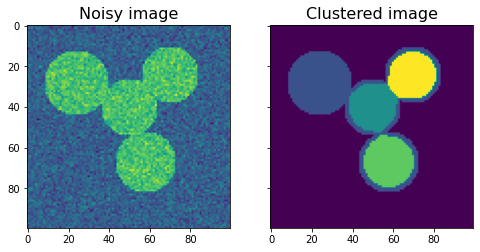

In [26]:
### Plot the images 

f, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,4))
ax1.imshow(imgn)
ax1.set_title('Noisy image', fontsize = 16)
ax2.imshow(label_im)
ax2.set_title('Clustered image', fontsize = 16)